In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from IPython.display import Image
import os
!ls ../input/
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **The goal of this notebook was to do something different from the others and to show my abilities to approach a problem and my skills in Python.**

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import joblib

from optuna.samplers import TPESampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [ ]:
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
item_categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')


# **Check if there is NaN values**

In [ ]:
number_errors=sales_train.isna().sum()

# **Creating the Dataset**
   **The goal of the competition is to predict the future sales for November 2015. At a first glance, we will predict this for October 2015 in order to find the best model possible. We have to create our Dataset. Firstly, we need to compute the sum for each month for each product and shop. We need to be careful and to compute, therefore, the mean of the item price for each month. Also, we have to clip the value between 0 and 20 because the true target values are between those values (constraint from the competition rules). In order to create a model based on the results of the prediction of October 2015, I choose to add for each month the couple (shop_id, item_id) if it does not exist. Moreover, I have to fill the columns "item_name" and "item_price". For "item_name", I will use Label Encoder because there is to many items and OneHotEncoder is too heavy for my computer in this case. For "item_price", I will use SimpleImputer (mean) and adding a column describing that we have filled the NaN values.**

In [ ]:
X = sales_train.groupby(["date_block_num","shop_id","item_id"]).agg({"item_price":"mean","item_cnt_day":"sum"})
X.reset_index(inplace = True)
X.rename(columns = {"item_cnt_day":"item_cnt_month"}, inplace = True)
X = X.merge(items, how = "left", on = ["item_id"])
list_month = list(X["date_block_num"].unique())
X.set_index("date_block_num", inplace = True)
X["item_cnt_month"] = X["item_cnt_month"].clip(0,20)
X_test = X.loc[33,:]
Y_test = X_test.loc[:,"item_cnt_month"]
X_test.drop("item_cnt_month",axis = 1, inplace = True)
X_oct_2015_concat = X.loc[33,["shop_id", "item_id", "item_name", "item_category_id"]]
X_oct_2015_concat.reset_index(inplace = True)
X.reset_index(inplace = True)
X_new = pd.DataFrame()
for i in list_month:
    X_new = pd.concat([X_new,X[(X["date_block_num"] == int(i))]], axis = 0)
    X_oct_2015_concat["date_block_num"].replace(33, int(i), inplace = True)
    X_new = pd.concat([X_new,X_oct_2015_concat], axis = 0)
X_new.drop_duplicates(subset = ["shop_id","item_id","date_block_num"], inplace = True)
X_new.isna().sum()


# **Label Encoder**


In [ ]:
categ_var=(X_new.dtypes=="object")
categ_var=list(categ_var[categ_var].index)
label_encoder=LabelEncoder()
for categ_col in categ_var:
    X_new[categ_col]=label_encoder.fit_transform(X_new[categ_col])
    X_test[categ_col]=label_encoder.transform(X_test[categ_col])

# **Missing Values**

In [ ]:
X_new["item_cnt_month"].fillna(0, inplace = True)
X_new["item_price_" + 'missed'] = X_new["item_price"].isnull()
X_test["item_price_" + 'missed'] = X_test["item_price"].isnull()
my_imputer = SimpleImputer()
X_train = pd.DataFrame(my_imputer.fit_transform(X_new))
X_train.columns = X_new.columns
Y_train=X_train.loc[:,"item_cnt_month"]
X_train.drop("item_cnt_month", axis = 1, inplace = True)
X_train.set_index("date_block_num", inplace = True)

# **Modelling**
**I will use Optuna in order to find the best parameters for my model. I choose LightGBM because it is faster than XGBoost and the accuracy are nearly the same.**

In [ ]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',50,100),
    max_depth = trial.suggest_int('max_depth',1,50),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',70,200),
    num_threads = trial.suggest_int('num_threads',1,50),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,50),
    lambda_l1=trial.suggest_uniform('lambda_l1',0,5)
    
#voir les diff trial qui existe
    model = lgb.LGBMRegressor(
        verbosity = 1,
        bagging_seed = 0,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'auc',
        lambda_l1=lambda_l1,
        bagging_freq = bagging_freq ,
        min_data_in_leaf = min_data_in_leaf,
        max_depth = max_depth,
        learning_rate = learning_rate,
        num_leaves = num_leaves,
        num_threads = num_threads,
        min_sum_hessian_in_leaf = min_sum_hessian_in_leaf)

    model.fit(X_train,Y_train)
    pred=model.predict(X_test)
    score_mae=mean_squared_error(Y_test, pred)
    return np.sqrt(score_mae)

sampler = TPESampler(seed = 10)
study = optuna.create_study(direction = "minimize", sampler = sampler)
study.optimize(objective, n_trials = 100)

In [ ]:
joblib.dump(study.best_params, "new.joblib")
best_params=joblib.load('new.joblib')

# **Train the model with the best parameters**

In [ ]:
model = lgb.LGBMRegressor(
        verbosity = 1,
        bagging_seed = 0,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'mse',
        **best_params,
        n_estimators=1000)
model.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)])
pred=model.predict(X_test)
score_mae=np.sqrt(mean_squared_error(Y_test,pred))
print(score_mae)
lgb.plot_metric(model)


**We can conclude that the model is underfitting a little but the root mean squared error are quiet good = 1.7607603980387614. In fact, the best scores for this competition are near 1 when they try to predict for October 2015 and it was because they do not use the item_price and item_name. The goal of this notebook was to do something different from the others and to show my abilities to approach a problem and my skills in Python.**

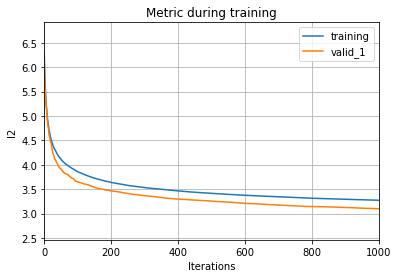

In [5]:
Image("../input/metric-plot/download (1).png")